In [365]:
import numpy as np
import pandas as pd

import os, glob, re, scipy.io
import seaborn as sns
from joblib import dump, load
import matplotlib.pyplot as plt
    

###############################################################################
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.utils.multiclass import unique_labels

###############################################################################
from keras.models import Model
from keras.preprocessing import image
# Pretrained
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_ppi
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_ppi
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input as Res50V2_ppi
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inceptv3_ppi
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input as moblv2_ppi

###############################################################################
#from StanfordCars import *


%matplotlib inline

# --- ROC Curves

def create_ROC_Curves(y, ypred, classes=[1,2,3]):
    fpr = dict()
    tpr = dict()
    auc_value = dict()
    
    # --- Binarize the true and preds
    y_true_bin = label_binarize(y, classes)
    #y_pred_bin = label_binarize(ypred, classes)
    #print(y_true_bin.shape)
    
    labels = {
        1: "ROC Curve for Convertibles",
        2: "ROC Curve for Sedans",
        3: "ROC Curve for SUVs/Trucks/Vans"
    }
    
    # --- Get FPR, TPR & AUC for each class
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:,i], ypred[:,i])
        #print(len(fpr[i]))
        auc_value[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=labels[i+1]+" (area = {:.2f})".format(auc_value[i]),
                 linestyle = ":", lw=3)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.legend(loc="lower right", fontsize=15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("Multi-class ROC for Classifying Car Images: One class vs Rest", fontsize = 18)
    plt.show()
    

PRETRAINED_MODELS = {
    'VGG16': {
        'model': VGG16,
        'preprocess': vgg16_ppi,
        'shape': (224, 224)
    },
    'VGG19': {
        'model': VGG19,
        'preprocess': vgg19_ppi,
        'shape': (224, 224)
    },
    'ResNet50V2': {
        'model': ResNet50V2,
        'preprocess': Res50V2_ppi,
        'shape': (224, 224)
    },
    'InceptionV3': {
        'model': InceptionV3,
        'preprocess': inceptv3_ppi,
        'shape': (299, 299)
    },
    'MobileNetV2': {
        'model': MobileNetV2,
        'preprocess': moblv2_ppi,
        'shape': (224, 224)
    }
}


class cars_model_class():
    """
    """
    
    def __init__(self, cnn="MobileNetV2", no_of_classes = 3, path="../Data/"):
        """
        
        properties:
        - cnn 
        - no_of_classes
        - classes
        - features_file
        - target_labels_file
        - train_test (a list to identify a train/test datapoint)
        
        """
        
        if cnn in PRETRAINED_MODELS.keys():
            self.cnn = cnn
        self.no_of_classes = no_of_classes
        self.features_file = path + "features/" + self.cnn + ".csv"
        self.target_labels_file = path + "cars_labels_train_test.csv"
        
        self.get_data()
    
    def get_data(self):
        """
        """
        features_df = pd.read_csv(self.features_file)
        targets_df = pd.read_csv(self.target_labels_file)
        
        # --- Get the class names and labels columns
        if self.no_of_classes == 3:
            target_column = "Label1_No"
            target_labels = "Label1"
        elif self.no_of_classes == 5:
            target_column = "Label2_No"
            target_labels = "Label2"
        else:
            target_column = "class_no"
            target_labels = "class_label"
            
        # --- Get train-test split as binary var: train as 0 & test as 1
        self.train_test = np.array(targets_df.loc[:,'trn0tst1'])
        
        self.Xtrain = features_df[ self.train_test == 0 ].iloc[:,2:]
        self.xtest = features_df[ self.train_test == 1 ].iloc[:,2:]
        self.Xtrain_fileName = features_df[ self.train_test == 0 ].iloc[:,1]
        self.xtest_fileName = features_df[ self.train_test == 1 ].iloc[:,1]
        
        self.Ytrain = targets_df[ self.train_test == 0 ][target_column]
        self.ytest = targets_df[ self.train_test == 1 ][target_column]
        
    def make_model():
        pass
    
    def build_misclass_df(self, ypred_lbls, ypred_proba):
        """
        """
        
        # --- Build up numpy ndarray adding one column at a time.
        # ---   yTrue <== yPred Labels first, then <== add yPred Probability , then <== fileNames
        temp_ytrue_preds = np.append(np.array(self.ytest).reshape(-1, 1), ypred_lbls.reshape(-1, 1), axis=1)
        temp_y_wpred_proba = np.append(temp_ytrue_preds, ypred_proba, axis=1)
        temp_fileNames = np.array(self.xtest_fileName).reshape(-1, 1)
        temp_array = np.append(temp_fileNames, temp_y_wpred_proba, axis=1)
        
        cols = ["fileName", "ytrue_lbl", "ypred_lbl"] + [str(i) for i in range(1, self.no_of_classes + 1)]
        
        test_wPreds_df = pd.DataFrame(temp_array, columns=cols)
        
        #temp_df.sort_values('2', ascending=False, inplace=True)
        #np.array(temp_df[(temp_df['ytrue_lbl']==1.0) & ((temp_df["ypred_lbl"])==2.0)].head(20)['fileName'])
        return test_wPreds_df
    
    def get_misclass_topFileNames(self, ypred_lbls, ypred_proba, ytrue, yfalse, number_of_imgs=10):
        """
        """
        # --- Get a combined dataframe with filenames, true test labels, predicted test labels and predict probas
        df_wpreds = self.build_misclass_df(ypred_lbls, ypred_proba)
        
        # --- Build up dataframe to an array of top fileNames
        fileNames_df = df_wpreds[(df_wpreds['ytrue_lbl']==float(ytrue)) & ((df_wpreds["ypred_lbl"])==float(yfalse))]
        fileNames_df.sort_values(str(int(yfalse)), ascending=False, inplace=True)

        no_of_misclass = fileNames_df.shape[0]
        
        # --- Create a list of image file names from the misclassified indices "list_of_indices"
        to_return = number_of_imgs
        if no_of_misclass == 0:
            to_return = 0
        elif no_of_misclass < number_of_imgs:
            to_return = no_of_misclass
        
        fileNames_to_return = np.array(fileNames_df['fileName'].head(to_return))
        
        return fileNames_to_return
         

In [366]:
import numpy as np
import pandas as pd

import os, glob, re, scipy.io
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.models import Model

class GetStandfordCars:
    """
    
    
    """
    
    def __init__(self, loc="../Data/car_ims/", labels_matlab_file ="../Data/cars_annos.mat"):
        
        self.car_images_location = loc
        self.labels_mat = scipy.io.loadmat(labels_matlab_file)
        
        # --- class names
        self.number_of_classes = len(self.labels_mat['class_names'][0])
        self.class_names = [str(self.labels_mat['class_names'][0][i][0]) for i in range(self.number_of_classes)]
        
        
        self.max_pics = 16185
        
        self.annot_df = self.create_annot_df()
        self.class_names_df = self.create_class_df()
        
        # --- for future
        #  Code to check if the 'loc' is a valid dataset
        #  if not, download data and unzip
        #  same for the labels matlab file
        
    
    def bring_annot(self, fileName):
        """
        """
        
        if type(fileName) == str:
            numb = int(re.sub(r'[^0-9]', '', fileName))
        else:
            numb = int(fileName)

        return ((self.labels_mat['annotations'][0][numb-1]))  
    
    
    def bringup_ClassLabel(self, fileName):
        if type(fileName) == str:
            numb = int(re.sub(r'[^0-9]', '', fileName))
        else:
            numb = int(fileName)

        #print("Class of image {}: {}".format(fileName, class_labels[int(mat['annotations'][0][numb-1][5])-1][0]))
        return self.class_names[int(self.labels_mat['annotations'][0][numb-1][5])-1]

        
    def bring_AnnotList(self, fileName):
        """
        """
        
        if type(fileName) == str:
            numb = int(re.sub(r'[^0-9]', '', fileName))
        else:
            numb = int(fileName)
        
        annot_array = self.bring_annot(numb)
        xmin = annot_array[1][0][0]
        ymin = annot_array[2][0][0]
        xmax = annot_array[3][0][0]
        ymax = annot_array[4][0][0]
        class_no = annot_array[5][0][0]
        class_label = self.bringup_ClassLabel(numb)
        train_test = annot_array[6][0][0]
        
        # --- file number, xmin, ymin, xmax, ymax, class no, train(0)/test(1)
        annot = [numb, xmin, ymin, xmax, ymax, class_no, class_label, train_test]

        return annot  
    
    def create_annot_df(self):
        
        list_df = []
        
        for fileName in range(1, self.max_pics + 1):
            list_df.append(self.bring_AnnotList(fileName))
            
        cols = ["fileNumber", "xmin", "ymin", "xmax", "ymax", "class_no", "class_label", "train_test"]
        
        return pd.DataFrame(list_df, columns = cols)
    
    def create_class_df(self):
        pass
    
    def getImages_by_class(self):
        pass
    
    def show_annots(self, fileName):
        """
        """

        if type(fileName) == str:
            numb = int(re.sub(r'[^0-9]', '', fileName))
        else:
            numb = int(fileName)

        print("Annot:     "+str(cars.labels_mat['annotations'][0][numb-1]))
        print("File Name: "+str(cars.labels_mat['annotations'][0][numb-1][0][0]))
        print("x min:     "+str(cars.labels_mat['annotations'][0][numb-1][1][0][0]))
        print("y min:     "+str(cars.labels_mat['annotations'][0][numb-1][2][0][0]))
        print("x max:     "+str(cars.labels_mat['annotations'][0][numb-1][3][0][0]))
        print("y max:     "+str(cars.labels_mat['annotations'][0][numb-1][4][0][0]))
        print("class no:  "+str(cars.labels_mat['annotations'][0][numb-1][5][0][0]))
        print("Train(0)/Test(1): "+str(cars.labels_mat['annotations'][0][numb-1][6][0][0]))

    
    def getPath(self, number):
        
        if type(number) == str:
            numb = int(re.sub(r'[^0-9]', '', number))
        else:
            numb = int(number)
        
        fileName  = str('0') * int(6 - len(str(numb)))

        fileName += str(numb)+".jpg"
        return (self.car_images_location + fileName)

    
    def getImgArray(self, number, target_size=(224, 224) ):
        img_path =  self.getPath(number)
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        return x
    

    def getNextImgArray(self, target_size=(224, 224) ):
        count = 0
        
        while count<self.max_pics:
            count += 1        
        
            yield (count, self.getImgArray(count, target_size))
    

    def showRandomNxN(self, N):
        '''
        Function to plot the MNIST data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 30]

        listofRand = np.random.randint(1, self.max_pics + 1, size=int(N*N))

        image_size = (128, 128)

        fig = plt.figure()

        for i in range(0, N*N):
            img = image.load_img(self.getPath(listofRand[i]), target_size=image_size)
            ax = fig.add_subplot(N, N, i+1)
            imgplot = ax.imshow(img)
            ax.set_title(self.bringup_ClassLabel(listofRand[i]))
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

        plt.show();
    
    
    def show_classNxN(self, class_no = 20, N=4):
        '''
        Function to plot image data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 30]
        
        list_of_images = list(self.annot_df.loc[self.annot_df["class_no"] == class_no]["fileNumber"])

        listofRand = np.random.choice(list_of_images, size = N*N, replace=False)

        image_size = (128, 128)

        fig = plt.figure()

        for i in range(0, N*N):
            img = image.load_img(self.getPath(listofRand[i]), target_size=image_size)
            ax = fig.add_subplot(N, N, i+1)
            imgplot = ax.imshow(img)
            ax.set_title(self.bringup_ClassLabel(listofRand[i]))
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

        plt.show();
        
    def show_select_images(self, list_of_images):
        '''
        Function to plot image data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 30]

        no_of_images = len(list_of_images)
        
        rows = no_of_images // 5 + int((no_of_images % 5) > 0)

        image_size = (128, 128)

        fig = plt.figure()
        
        img_no = 1
        for file_no in list_of_images:
            img = image.load_img(self.getPath(file_no), target_size=image_size)
            ax = fig.add_subplot(rows, 5, img_no)
            img_no += 1
            imgplot = ax.imshow(img)
            ax.set_title(self.bringup_ClassLabel(file_no))
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

        plt.show();
        
    def show_1EachClass7x7(self, quarter = 1):
        '''
        Function to plot image data on a grid of NxN
        '''
        assert quarter <= 4
        
        plt.rcParams['figure.figsize'] = [30, 30]
        
        fig = plt.figure()
        
        for class_no in range((quarter-1)*49, quarter*49):
            
            list_of_images = list(self.annot_df.loc[self.annot_df["class_no"] == class_no + 1]["fileNumber"])
            listofRand = np.random.choice(list_of_images, size = 1, replace=False)
            image_size = (128, 128)

            
            img = image.load_img(self.getPath(listofRand[0]), target_size=image_size)
            ax = fig.add_subplot(7, 7, class_no + 1 - (quarter-1)*49)
            imgplot = ax.imshow(img)
            ax.set_title("Class "+str(class_no+1)+ " " + self.bringup_ClassLabel(listofRand[0]))
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

        plt.show();

In [367]:
cars_model = cars_model_class()   

Xtrn = cars_model.Xtrain
xtst = cars_model.xtest
Ytrn = cars_model.Ytrain
ytst = cars_model.ytest

#avgScores = []
#Ms = range(200, 550, 50)

#for M in Ms:
#    testPCA = PCA(n_components=M)
#    testPCA.fit(Xtrn)
#    avgScores.append(np.sum(testPCA.explained_variance_ratio_))
#    #print(testPCA.score(X_train))

#plt.plot(Ms, avgScores)

In [368]:
cars_PCA = PCA(n_components=500)

Xtrn_500 = cars_PCA.fit_transform(Xtrn)
xtst_500 = cars_PCA.transform(xtst)

print(np.sum(cars_PCA.explained_variance_ratio_))

0.9248370568790517


In [369]:
logreg = LogisticRegression(C=100000, verbose=True, solver="saga", max_iter=500) # C: Inverse of regularization strength; 
logreg.fit(Xtrn_500, Ytrn)

#randomforest = RandomForestClassifier(n_estimators=100)
#quick_test_afew_times(randomforest, X, y1)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 92 epochs took 4 seconds
convergence after 61 epochs took 3 seconds
convergence after 182 epochs took 8 seconds


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.0s finished


LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=True,
                   warm_start=False)

Train Score for the Logit Model: 0.844
Test Score for the Logit Model: 0.820
Confusion matrix: 

 [[ 846  171   14]
 [ 178  759  109]
 [  18   92 1050]]


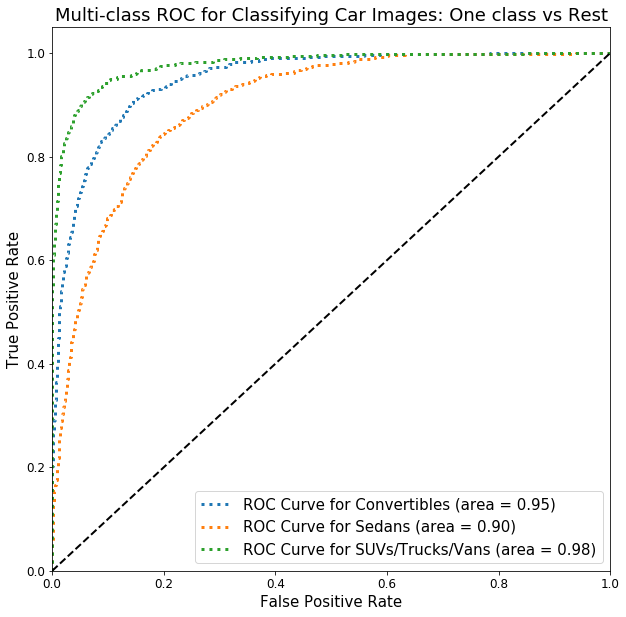

In [370]:
ytest_labels = logreg.predict(xtst_500)
ytest_prob = logreg.predict_proba(xtst_500)
train_score = logreg.score(Xtrn_500, Ytrn)
test_score = logreg.score(xtst_500, ytst)
print("Train Score for the Logit Model: {:.3f}".format(train_score))
print("Test Score for the Logit Model: {:.3f}".format(test_score))
print("Confusion matrix: \n\n", confusion_matrix(ytst, ytest_labels))

plt.rcParams['figure.figsize'] = [10, 10]
create_ROC_Curves(ytst, ytest_prob)

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


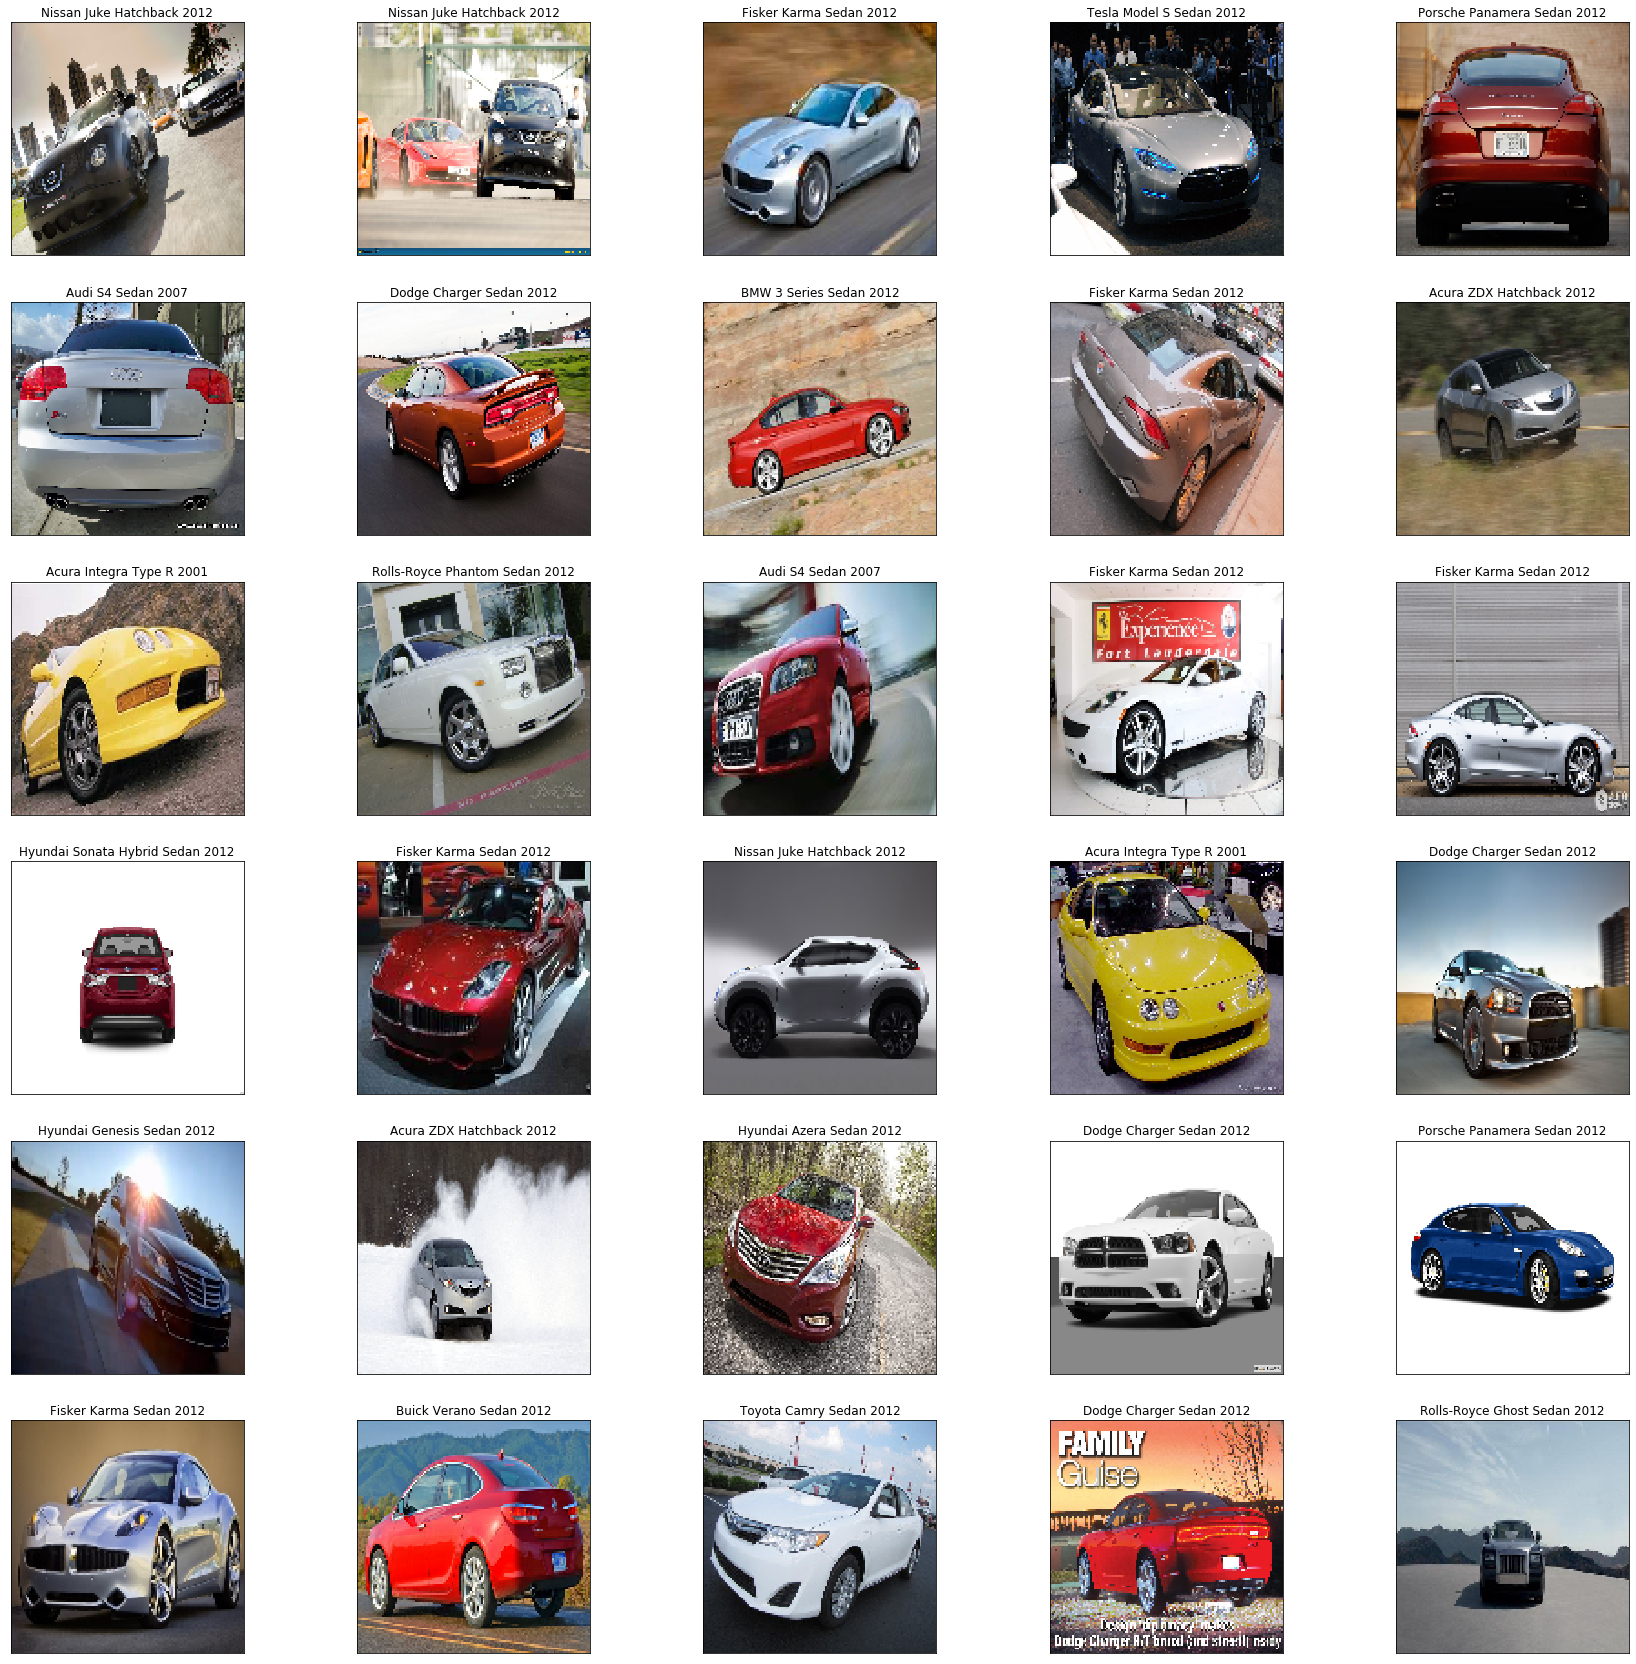

In [386]:
top20_12 = cars_model.get_misclass_topFileNames(ytest_labels, ytest_prob, 2, 1, 30)
GetStandfordCars().show_select_images(top20_12)

#print(GetStandfordCars().getPath(13201.0))

In [381]:
randomforest = RandomForestClassifier(n_estimators=200, max_depth=50)
randomforest.fit(Xtrn_500, Ytrn)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Train Score for the Logit Model: 1.000
Test Score for the Logit Model: 0.770
Confusion matrix: 

 [[ 726  278   27]
 [ 177  684  185]
 [  21  109 1030]]


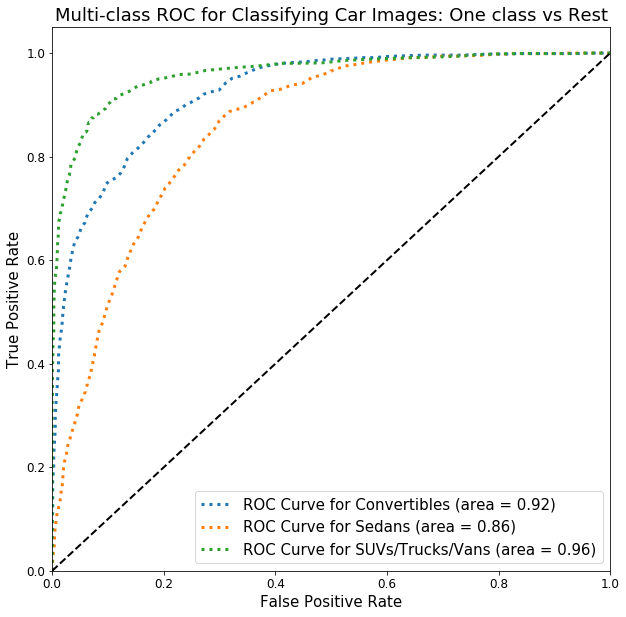

In [382]:
ytest_labels_rf = randomforest.predict(xtst_500)
ytest_prob_rf = randomforest.predict_proba(xtst_500)
train_score_rf = randomforest.score(Xtrn_500, Ytrn)
test_score_rf = randomforest.score(xtst_500, ytst)
print("Train Score for the Logit Model: {:.3f}".format(train_score_rf))
print("Test Score for the Logit Model: {:.3f}".format(test_score_rf))
print("Confusion matrix: \n\n", confusion_matrix(ytst, ytest_labels_rf2))

plt.rcParams['figure.figsize'] = [10, 10]
create_ROC_Curves(ytst, ytest_prob_rf)

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


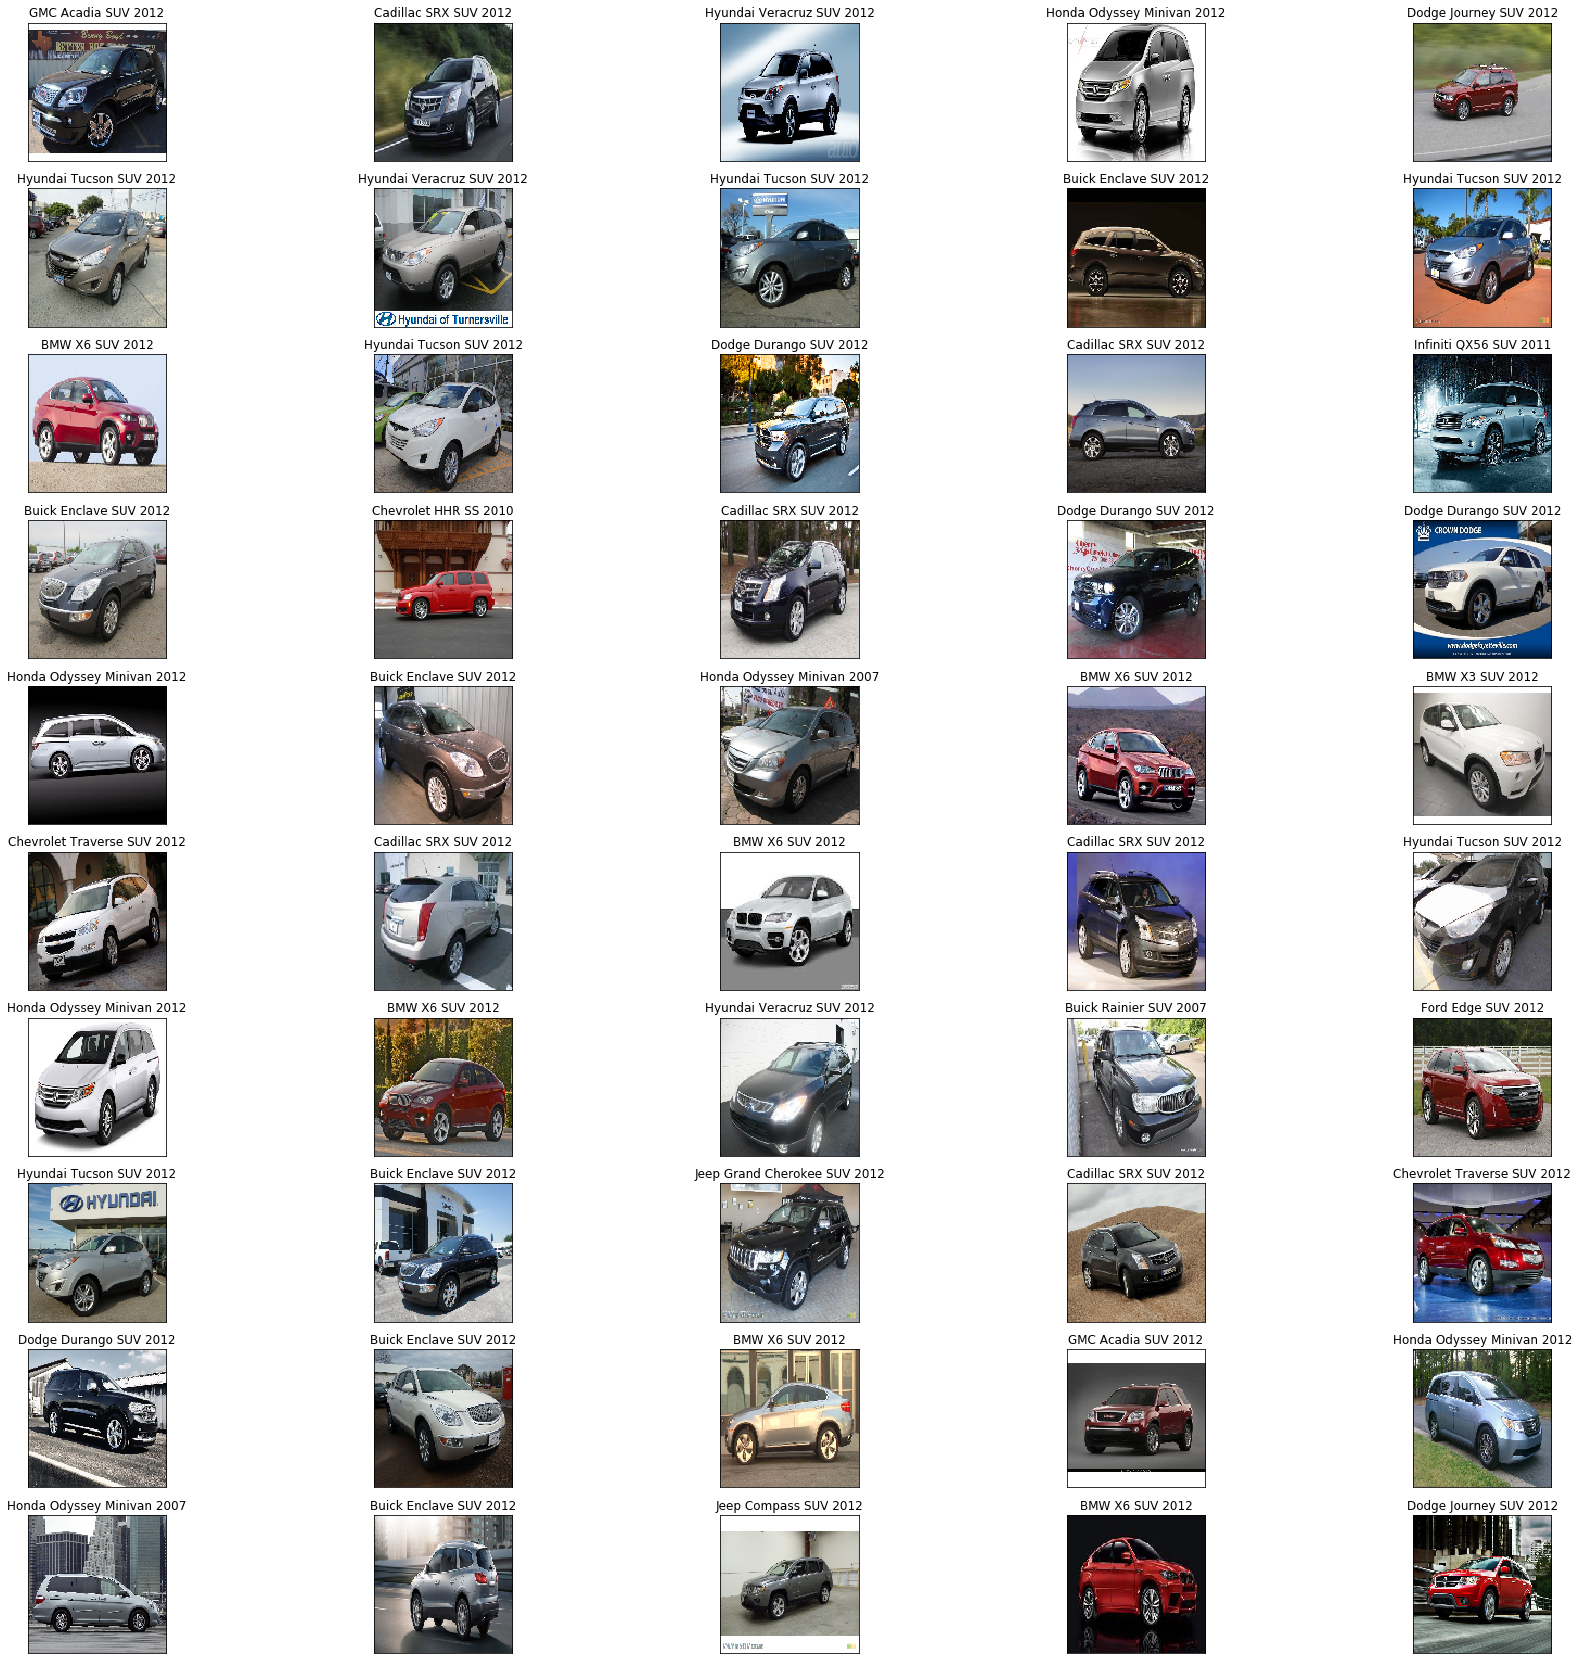

In [387]:
top20_rf = cars_model.get_misclass_topFileNames(ytest_labels_rf, ytest_prob_rf, 3, 2, 50)
GetStandfordCars().show_select_images(top20_rf)

In [80]:
cars_svc = SVC(kernel='poly', gamma='auto', probability=True, verbose=True)
cars_svc.fit(Xtrn_500, Ytrn)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=True)

In [81]:
ytest_labels_svc = cars_svc.predict(xtst_500)
ytest_prob_svc = cars_svc.predict_proba(xtst_500)
train_score_svc = cars_svc.score(Xtrn_500, Ytrn)
test_score_svc = cars_svc.score(xtst_500, ytst)
print("Train Score for the Logit Model: {:.3f}".format(train_score_svc))
print("Test Score for the Logit Model: {:.3f}".format(test_score_svc))

plt.rcParams['figure.figsize'] = [10, 10]

Train Score for the Logit Model: 0.705
Test Score for the Logit Model: 0.689


In [82]:
dump(logreg, "../Models/MobileNetV2/LogReg1_wPCA_Model1.joblib")
dump(cars_svc, "../Models/MobileNetV2/SVC1_wPCA_Model1.joblib")
dump(randomforest, "../Models/MobileNetV2/RFq_wPCA_Model1.joblib")

['../Models/MobileNetV2/RFq_wPCA_Model1.joblib']

In [83]:
print("F1 score for logistic regression: {}".format(f1_score(ytst, ytest_labels, average="macro")))
print("F1 score for SVC: {}".format(f1_score(ytst, ytest_labels_svc, average="macro")))
print("F1 score for Randon=m Forest: {}".format(f1_score(ytst, ytest_labels_rf, average="macro")))

F1 score for logistic regression: 0.8127504800130322
F1 score for SVC: 0.688893368827459
F1 score for Randon=m Forest: 0.7424765246889211


In [84]:
print("AUC for logistic regression: {}".format(auc(ytst.ravel(), ytest_labels.ravel(), average="macro")))
print("AUC for SVC: {}".format(auc(ytst.ravel(), ytest_labels_svc.ravel(), average="macro")))
print("AUC for Randon=m Forest: {}".format(auc(ytst.ravel(), ytest_labels_rf.ravel(), average="macro")))

ValueError: multiclass format is not supported

Train Score for the Logit Model: 0.780
Test Score for the Logit Model: 0.744
Confusion matrix: 

 [[726 278  27]
 [178 689 221]
 [ 20 104 994]]


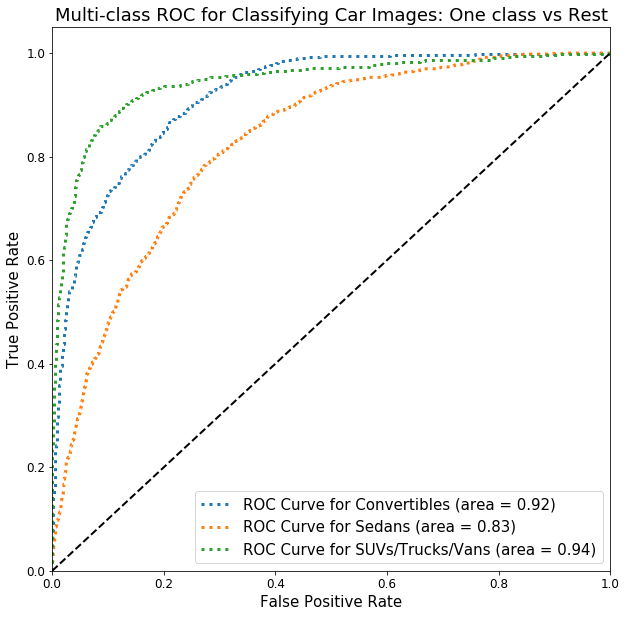

In [8]:
randomforest2 = RandomForestClassifier(n_estimators=200, criterion="entropy", max_depth=5, random_state=333)
randomforest2.fit(Xtrn_500, Ytrn)

ytest_labels_rf2 = randomforest2.predict(xtst_500)
ytest_prob_rf2 = randomforest2.predict_proba(xtst_500)
train_score_rf2 = randomforest2.score(Xtrn_500, Ytrn)
test_score_rf2 = randomforest2.score(xtst_500, ytst)
print("Train Score for the Logit Model: {:.3f}".format(train_score_rf2))
print("Test Score for the Logit Model: {:.3f}".format(test_score_rf2))
print("Confusion matrix: \n\n", confusion_matrix(ytst, ytest_labels_rf2))

plt.rcParams['figure.figsize'] = [10, 10]
create_ROC_Curves(ytst, ytest_prob_rf2)

1         2         3         4         5         6         7  \
0      0.624495  0.033813  0.908862  0.072910  0.004346  0.000000  1.228820   
1      0.000000  0.437930  0.000000  0.032143  0.000000  0.267990  0.064275   
2      0.585322  0.001067  0.024649  0.016769  0.174261  0.411321  0.262137   
4      1.143764  0.060055  0.003831  0.000000  0.075050  0.473232  0.380867   
6      0.000000  0.005777  0.097228  0.000000  0.000000  0.000000  0.089882   
...         ...       ...       ...       ...       ...       ...       ...   
16177  1.111427  0.554532  0.000000  0.000000  0.192450  0.129396  0.000000   
16180  0.612718  0.140077  0.000000  0.000000  0.448265  1.792741  0.000000   
16181  0.877511  0.422268  0.016902  0.000000  0.039809  0.779360  0.007548   
16182  0.448333  1.070562  0.150521  0.000000  0.000000  0.017197  0.000000   
16183  0.030525  2.035002  0.196992  0.023985  0.076134  0.157399  0.000000   

              8         9        10  ...      1271      1272      1273  \
0      0.818473  0.033905  0.038722  ...  0.201633  0.134262  0.000000   
1      0.819570  0.000000  0.000000  ...  2.181230  0.000000  0.188090   
2      0.000000  0.000000  0.020481  ...  0.463402  0.870228  0.000000   
4      1.108273  0.377539  0.000000  ...  1.719604  1.339719  0.112092   
6      0.000000  0.000000  0.000000  ...  0.271227  0.409838  0.000000   
...         ...       ...       ...  ...       ...       ...       ...   
16177  0.310809  0.000000  0.000000  ...  0.124613  0.063905  0.000000   
16180  0.000000  0.079836  0.000000  ...  0.006563  0.000000  0.000000   
16181  0.000000  0.000000  0.000000  ...  0.068560  0.167950  0.000000   
16182  0.110758  0.000000  0.201016  ...  0.060986  0.000000  0.000000   
16183  0.212373  2.169023  0.000000  ...  1.538965  0.000000  0.000000   

           1274      1275      1276      1277      1278      1279      1280  
0      0.350688  0.000000  2.198918  0.248370  2.500723  1.304098  0.031497  
1      0.962528  0.810423  0.141051  0.000000  0.269119  0.667619  0.307729  
2      0.094198  0.195522  0.000000  0.043474  0.046253  0.000000  0.025333  
4      0.576496  0.000000  0.000000  0.000000  0.229518  0.008216  0.735241  
6      0.396954  0.018865  0.000000  0.000000  0.000000  0.189686  0.000000  
...         ...       ...       ...       ...       ...       ...       ...  
16177  0.172059  0.000000  0.010446  0.000000  0.013380  1.539183  0.132436  
16180  0.649398  0.000000  0.000000  0.046293  0.194650  1.194046  0.037506  
16181  0.000000  0.000000  0.024853  0.049239  0.375023  0.274020  0.013824  
16182  0.313205  0.094281  0.218245  0.028336  0.315229  2.260771  0.000000  
16183  0.943409  0.772161  0.071015  0.350485  0.000000  0.226857  0.000000  

[12948 rows x 1280 columns]